In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import join, normpath
import roamability as rb

downloads = 'C:/Users/balob/Downloads'

In [2]:
start_date = '20190901'
end_date = '20191130'

sql_srt="""
SELECT * FROM
(
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,'DATA' AS UsageType
FROM aggreg.GPRS_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
UNION ALL
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,CASE WHEN Sms = 0 THEN 'MOC' WHEN Sms = 1 THEN 'MOSMS' END AS UsageType
FROM aggreg.MOC_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
UNION ALL
SELECT
Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue
,CASE WHEN Sms = 0 THEN 'MTC' WHEN Sms = 1 THEN 'MTSMS' END AS UsageType
FROM aggreg.MTC_AGR
WHERE `Day` BETWEEN {start_date} AND {end_date}
) t
""".format(start_date=start_date, end_date=end_date)

with rb.MySqlConnect('172.18.11.40', 'BSS', 'noc', 'WcQUzkXiXwoxnFfGnRxb') as cnxn:
    df_bss_source = pd.read_sql_query(sql_srt, cnxn)
df_bss_source.head(3)
# df_bss_source.to_csv(join(downloads, 'df_bss_source.csv'), index=False)

,Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue,UsageType
0,20190901,26006,11,30,172722,0.267997,0.581297,DATA
1,20190901,26006,14,50,172726,0.000959,0.002092,DATA
2,20190901,26006,14,50,172854,0.616376,1.336970,DATA


In [3]:
df_bss_source.to_csv(join(downloads, 'df_bss_source_2019_01-10.csv'), index=False)

In [2]:
df_bss_source = pd.read_csv(join(downloads, 'df_bss_source.csv'))
df_bss_source.head(3)

,Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue,UsageType
0,20180101,26006,21,78,172734,0.000228,0.000762,DATA
1,20180101,26006,21,79,172734,0.011428,0.018129,DATA
2,20180101,26006,21,81,172734,0.011826,0.019093,DATA


In [4]:
sql_srt='SELECT network_id AS VisitedNetworkId, MAX(tadig_code) AS Tadig FROM RDB_TADIG_CODES GROUP BY network_id;'
with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_tadig = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
display(df_tadig.head(3))

sql_srt='SELECT reseller_id AS Customer, reseller_name AS CustomerName FROM RESELLERS;'
with rb.MssqlConnect('172.18.11.82', '10028', 'BSS', 'iKQVm40AZAmyRaw72LeY') as cnxn:
    df_customer = pd.read_sql_query(sql_srt, cnxn, coerce_float=False)
    
df_customer.replace({'STI - Telinta':'STI'}, inplace=True)

display(df_customer.head(3))

,VisitedNetworkId,Tadig
0,4,AFGAW
1,5,AFGAR
2,6,AFGEA


,Customer,CustomerName
0,172711,Mondicon
1,172716,Cloud 9 TAP
2,172717,KnowRoaming IMSI-RANGE TAP


In [5]:
df_bss = df_bss_source.copy()
df_bss['Profit'] = df_bss['Revenue'] - df_bss['Cost']
df_bss.SponsorPrefix.replace({42501:1, 26006:2, 45403:4, 51503:5}, inplace=True)
df_bss = df_bss.pivot_table(values='Cost',index=['Day','SponsorPrefix','VisitedCountryId','VisitedNetworkId','Customer']
                   ,columns='UsageType', aggfunc=np.sum).reset_index()
df_bss.Day = pd.to_datetime(df_bss.Day, format='%Y%m%d')
df_bss.head(3)

UsageType,Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,DATA,MOC,MOSMS,MTC,MTSMS
0,2019-10-01,1,3,12,172716,3.192310,NaN,NaN,NaN,0.0
1,2019-10-01,1,3,12,172717,0.027492,NaN,NaN,NaN,NaN
2,2019-10-01,1,3,12,172722,3.819550,NaN,NaN,NaN,0.0


In [6]:
df_bss_processed = pd.merge(df_bss, df_customer, how='left', on='Customer')
df_bss_processed = pd.merge(df_bss_processed, df_tadig, how='left', on='VisitedNetworkId')
df_bss_processed = df_bss_processed[['Day','SponsorPrefix','CustomerName','Tadig','MOC','MTC','MOSMS','MTSMS','DATA']]
df_bss_processed['Month'] = df_bss_processed.Day.dt.strftime('%Y-%m')
df_bss_processed.head(3)

,Day,SponsorPrefix,CustomerName,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,Month
0,2019-10-01,1,Cloud 9 TAP,ALBVF,NaN,NaN,NaN,0.0,3.192310,2019-10
1,2019-10-01,1,KnowRoaming IMSI-RANGE TAP,ALBVF,NaN,NaN,NaN,NaN,0.027492,2019-10
2,2019-10-01,1,Naka TAP,ALBVF,NaN,NaN,NaN,0.0,3.819550,2019-10


In [7]:
# df_bss_processed.Day = df_bss_processed.Day.dt.round('7D')
# df_bss_processed.set_index('Day', inplace=True)
df_bss_processed['TotalProfit'] = df_bss_processed[['MOC','MTC','MOSMS','MTSMS','DATA']].sum(axis=1)
df_bss_processed.fillna(0, inplace=True)
df_bss_processed.head(3)

,Day,SponsorPrefix,CustomerName,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,Month,TotalProfit
0,2019-10-01,1,Cloud 9 TAP,ALBVF,0.0,0.0,0.0,0.0,3.192310,2019-10,3.192310
1,2019-10-01,1,KnowRoaming IMSI-RANGE TAP,ALBVF,0.0,0.0,0.0,0.0,0.027492,2019-10,0.027492
2,2019-10-01,1,Naka TAP,ALBVF,0.0,0.0,0.0,0.0,3.819550,2019-10,3.819550


In [8]:
df_bss_processed.loc[df_bss_processed.CustomerName.str.startswith('Vec', na=False),'CustomerName'].unique()

array(['Vectone TAP'], dtype=object)

In [10]:
df_bss_processed.loc[(df_bss_processed.CustomerName == 'Vectone TAP')].groupby(['SponsorPrefix','Tadig'])['TotalProfit'].sum()

SponsorPrefix  Tadig
1              CHEOR      6.269420
               DEUD2      0.003273
               GBRME      0.052521
               GEOMT      0.008751
               GHAGT      0.096289
               HKGTC      0.011560
               HRVVI      2.691125
               HUNH2    171.844000
               INDSC     19.868449
               IRLH3      0.135996
               JORMC      0.181200
               LKAHT      0.127000
               MDAMC      0.749875
               MEXMS      0.133208
               MNEMT      0.025046
               NZLBS      0.001500
               PERVT      0.000000
               POL03     23.304249
               POLP4      0.031198
               SRBNO      2.166022
               SVNSM      5.151580
               TZAVC      0.038836
2              ARM01      0.000000
               BGRCM     25.025041
               CYPCT      0.388120
               CZEET      7.281710
               CZERM      0.019349
               DEUD1      0.822789

In [14]:
# Prepare data for Country

df_bss_country = df_bss_processed[df_bss_processed.Tadig.str.startswith('CHE')].copy()
df_bss_country.tail(3)

,Day,SponsorPrefix,CustomerName,Tadig,MOC,MTC,MOSMS,MTSMS,DATA
3871,2019-12-03,2,Naka TAP,CHEDX,NaN,NaN,NaN,NaN,0.081317
4030,2019-12-04,1,KnowRoaming IMSI-RANGE TAP,CHEOA,NaN,NaN,NaN,0.0,NaN
4270,2019-12-04,2,Naka TAP,CHEDX,NaN,NaN,NaN,NaN,0.000000


C:\Users\balob\Miniconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


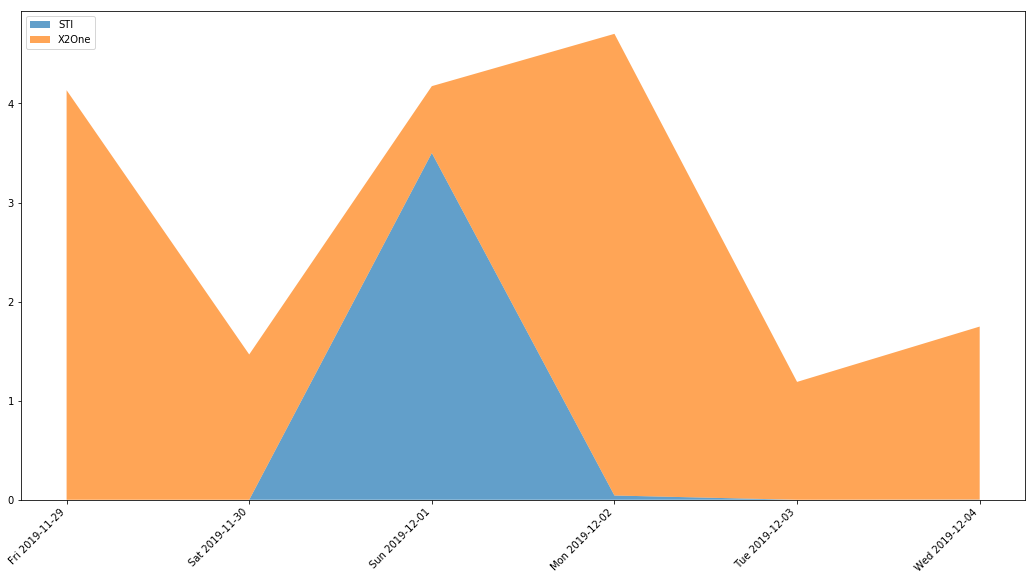

In [17]:
# Country by Customer
threshold = 0
country = 'HUNH2'

df_temp = df_bss_processed[df_bss_processed.Tadig.str.startswith(country)].copy()

s1 = df_temp.groupby(['Day','CustomerName'], as_index=False)['TotalProfit'].sum()\
.groupby(['CustomerName'])['TotalProfit'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed.CustomerName.isin(list_other), ['CustomerName']] = 'Others'

df_temp = df_temp.groupby(['Day','CustomerName'], as_index=False)['TotalProfit'].sum()

df_temp = df_temp.pivot_table(values='TotalProfit',index=['Day']
                   ,columns='CustomerName', aggfunc=np.sum).reset_index().sort_values(by='Day')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Day'].values, df_temp.drop('Day', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
xticks = df_temp.Day
plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

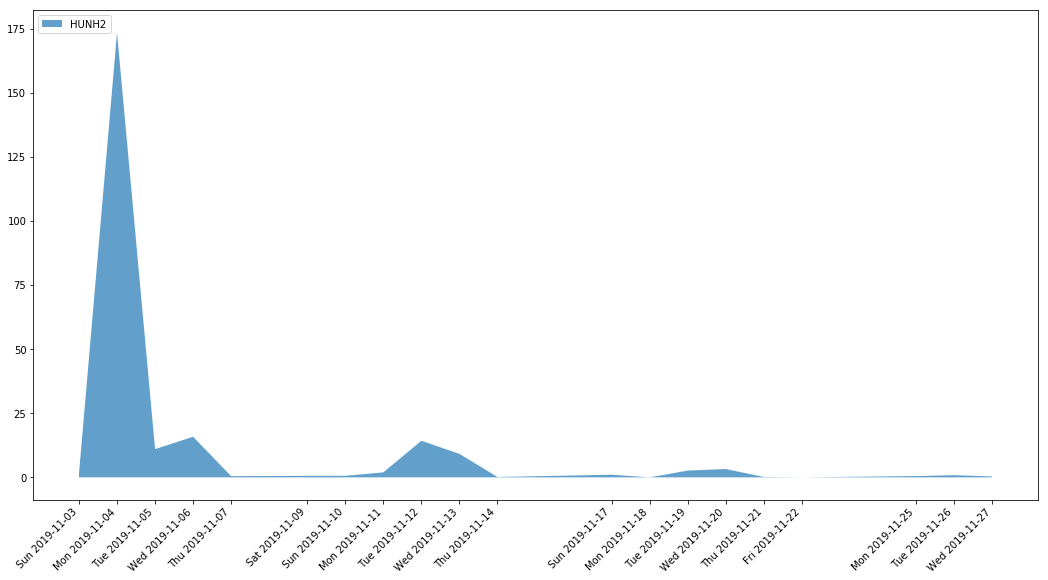

In [23]:
# Country by Tadig

threshold = 0
usage_type = 'TotalProfit'
country = 'HUNH2'

df_temp = df_bss_processed[df_bss_processed.Tadig.str.startswith(country)].copy()

s1 = df_temp.groupby(['Day','Tadig'], as_index=False)[usage_type].sum()\
.groupby(['Tadig'])[usage_type].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed.Tadig.isin(list_other), ['Tadig']] = 'Others'

df_temp = df_temp.groupby(['Day','Tadig'], as_index=False)[usage_type].sum()

df_temp = df_temp.pivot_table(values=usage_type,index=['Day']
                   ,columns='Tadig', aggfunc=np.sum).reset_index().sort_values(by='Day')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Day'].values, df_temp.drop('Day', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
xticks = df_temp.Day
plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

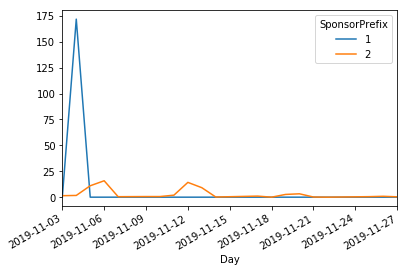

In [25]:
# Country by Sponsor
country = 'HUNH2'

df_bss_processed[df_bss_processed.Tadig.str.startswith(country)].\
groupby(['Day','SponsorPrefix'], as_index=False)['TotalProfit'].sum().\
pivot_table(values='TotalProfit',index=['Day']
                   ,columns='SponsorPrefix', aggfunc=np.sum).reset_index().sort_values(by='Day').fillna(0).set_index('Day')\
.plot()
plt.show()

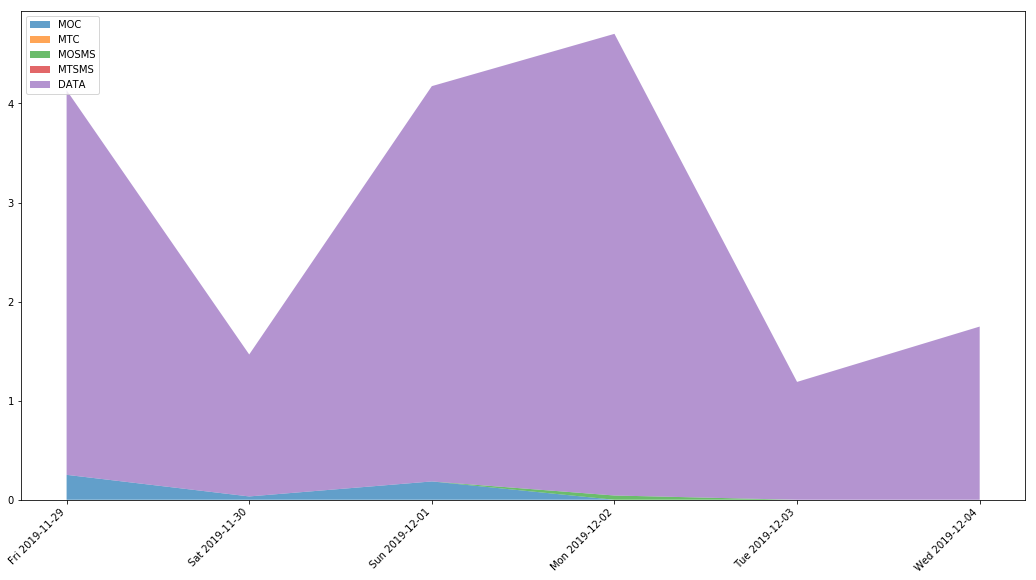

In [18]:
# Country by UsageType
country = 'HUNH2'

df_temp = df_bss_processed[df_bss_processed.Tadig.str.startswith(country)].\
groupby(['Day'], as_index=False)[['MOC','MTC','MOSMS','MTSMS','DATA']].sum().sort_values(by='Day').fillna(0)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Day'].values, df_temp.drop('Day', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
xticks = df_temp.Day
plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

In [9]:
df_bss_processed.loc[df_bss_processed.CustomerName.str.startswith('Vec'),'CustomerName'].unique()

array(['Vectone TAP'], dtype=object)

In [10]:
# Prepare data for Customer

df_bss_processed['TotalProfit'] = df_bss_processed[['MOC','MTC','MOSMS','MTSMS','DATA']].sum(axis=1)
df_bss_processed.fillna(0, inplace=True)
df_bss_processed.head(3)

df_bss_customer = df_bss_processed.loc[df_bss_processed.CustomerName == 'Joy_telecom'].copy()
df_bss_customer['Month'] = df_bss_customer['Day'].values.astype('<M8[M]')
df_bss_customer['Year'] = df_bss_customer['Day'].values.astype('<M8[Y]')
df_bss_customer.head(3)

,Day,SponsorPrefix,CustomerName,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TotalProfit,Month,Year
213,2019-11-29,1,Vectone TAP,INDSC,0.427771,0.0,0.000000,0.0,0.99869,1.426461,2019-11-01,2019-01-01
355,2019-11-29,1,Vectone TAP,MDAMC,0.000000,0.0,1.002280,0.0,0.00000,1.002280,2019-11-01,2019-01-01
452,2019-11-29,1,Vectone TAP,SRBNO,0.940109,0.0,1.009245,0.0,0.00000,1.949354,2019-11-01,2019-01-01


In [11]:
df_bss_customer.groupby(['SponsorPrefix','Tadig'], as_index=False).sum().to_excel(join(downloads, 'CUSTOMER_BSS_REPORT.xlsx'), 'Sheet1', index=False)
df_bss_customer.groupby(['SponsorPrefix','Tadig'], as_index=False).sum()

,SponsorPrefix,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TotalProfit
0,1,CHEOR,1.002280,0.0,0.000000,0.0,0.000000,1.002280
1,1,GEOMT,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,1,GHAGT,2.001864,0.0,0.000000,0.0,0.000000,2.001864
3,1,INDSC,1.194425,0.0,2.000432,0.0,2.994331,6.189188
4,1,JORMC,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,1,MDAMC,0.999820,0.0,1.002280,0.0,0.000000,2.002100
6,1,SRBNO,2.980867,0.0,3.028425,0.0,0.000000,6.009291
7,1,SVNSM,3.000859,0.0,0.999595,0.0,0.000000,4.000454
8,2,BGRCM,5.414320,0.0,3.252132,0.0,0.000000,8.666453
9,2,CYPCT,1.078430,0.0,0.000000,0.0,0.000000,1.078430


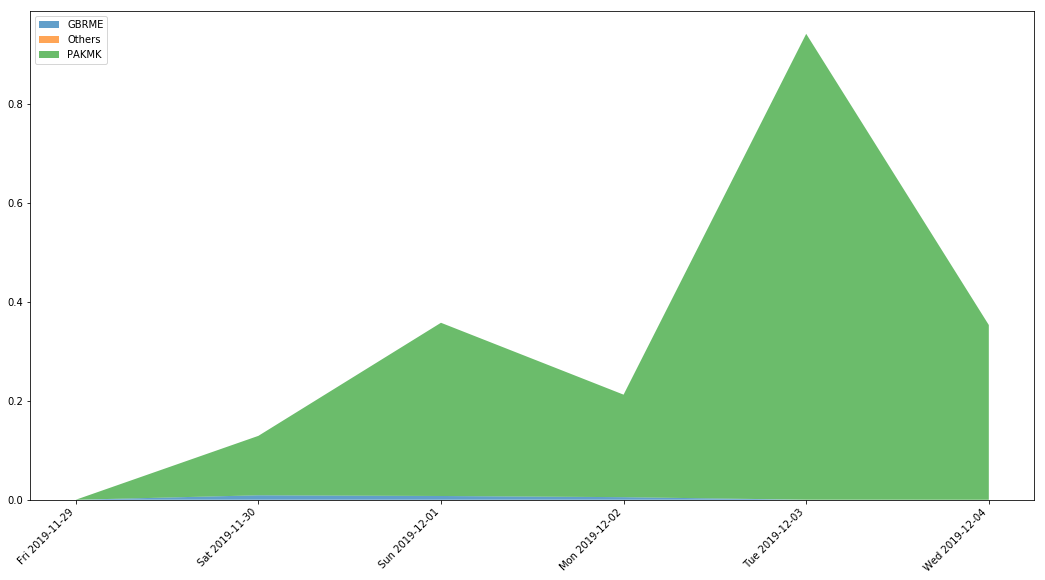

In [24]:
threshold = 0
customer = 'Joy_telecom'
sponsor = 2
usage_type = 'DATA'

df_temp = df_bss_processed[(df_bss_processed.CustomerName == customer) & (df_bss_processed.SponsorPrefix == sponsor)].copy()

s1 = df_temp.groupby(['Day','Tadig'], as_index=False)[usage_type].sum()\
.groupby(['Tadig'])[usage_type].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed.Tadig.isin(list_other), ['Tadig']] = 'Others'

df_temp = df_temp.groupby(['Day','Tadig'], as_index=False)[usage_type].sum()

df_temp = df_temp.pivot_table(values=usage_type,index=['Day']
                   ,columns='Tadig', aggfunc=np.sum).reset_index().sort_values(by='Day')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Day'].values, df_temp.drop('Day', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
xticks = df_temp.Day
plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

In [12]:
df_bss_processed = df_bss_processed[df_bss_processed.Tadig!='GTMSC']

df_bss_processed.loc[(df_bss_processed.CustomerName == 'Telzar 019 DMI RT') &
                (df_bss_processed.Day >= '2019-08-01') & (df_bss_processed.Day < '2019-09-01'), ['MOSMS']] = 0

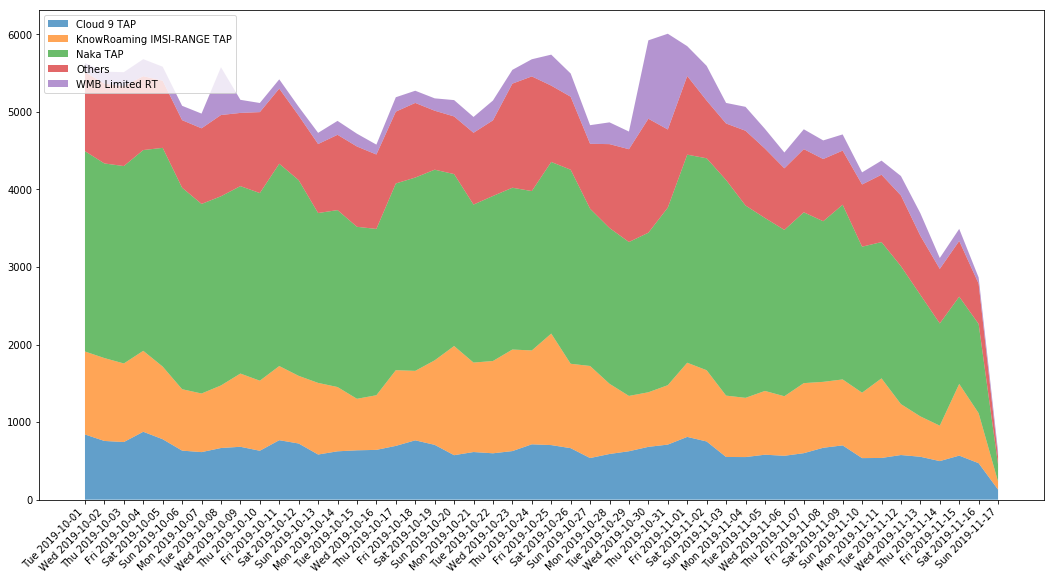

In [48]:
# Общая статистика по кастомерам

threshold = 800

df_temp = df_bss_processed.copy()
# df_temp = df_bss_processed[df_bss_processed.Day > '2019-10-18'].copy()

s1 = df_temp.groupby(['Day','CustomerName'], as_index=False)['TotalProfit'].sum()\
.groupby(['CustomerName'])['TotalProfit'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed.CustomerName.isin(list_other), ['CustomerName']] = 'Others'

df_temp = df_temp.groupby(['Day','CustomerName'], as_index=False)['TotalProfit'].sum()

df_temp = df_temp.pivot_table(values='TotalProfit',index=['Day']
                   ,columns='CustomerName', aggfunc=np.sum).reset_index().sort_values(by='Day')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Day'].values, df_temp.drop('Day', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
xticks = df_temp.Day
plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

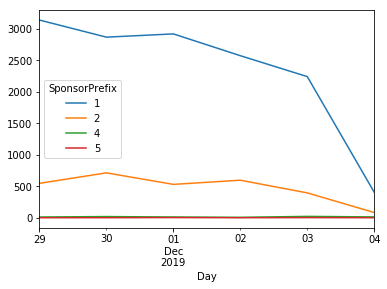

In [25]:
# Общая статистика по Спонсору

df_bss_processed.\
groupby(['Day','SponsorPrefix'], as_index=False)['TotalProfit'].sum().\
pivot_table(values='TotalProfit',index=['Day']
                   ,columns='SponsorPrefix', aggfunc=np.sum).reset_index().sort_values(by='Day').fillna(0).set_index('Day')\
.plot()
plt.show()

In [26]:
df_bss_processed.loc[df_bss_processed.CustomerName.str.startswith('Vec'),'CustomerName'].unique()

array(['Vectone TAP'], dtype=object)

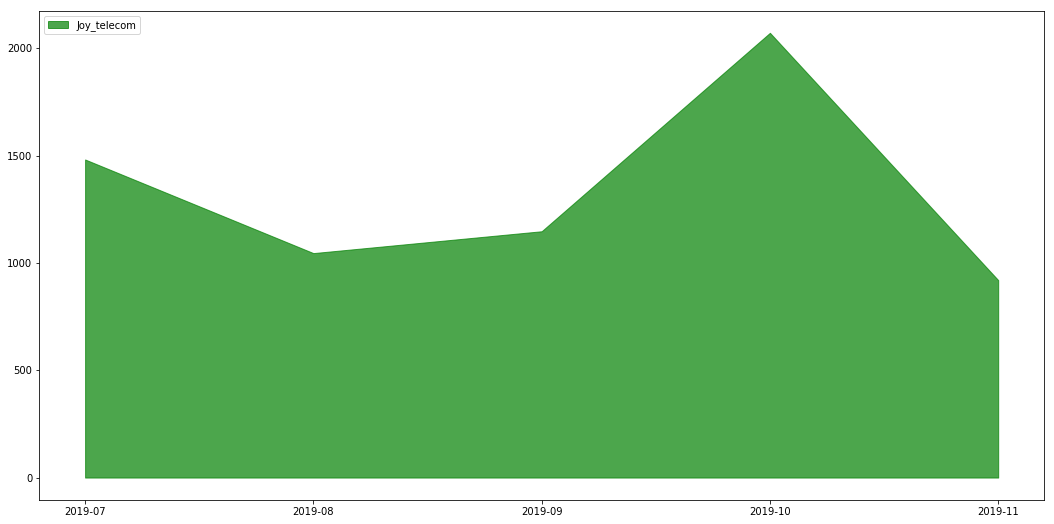

In [25]:
# Статистика по отдельному кастомеру

threshold = 0
customer_name = 'Joy_telecom'

df_temp = df_bss_processed[(df_bss_processed.CustomerName == customer_name)].copy()

s1 = df_temp.groupby(['Month','CustomerName'], as_index=False)['TotalProfit'].sum()\
.groupby(['CustomerName'])['TotalProfit'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed.CustomerName.isin(list_other), ['CustomerName']] = 'Others'

df_temp = df_temp.groupby(['Month','CustomerName'], as_index=False)['TotalProfit'].sum()

df_temp = df_temp.pivot_table(values='TotalProfit',index=['Month']
                   ,columns='CustomerName', aggfunc=np.sum).reset_index().sort_values(by='Month')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Month'].values, df_temp.drop('Month', axis=1).T, labels=df_temp.columns[1:], alpha=0.70, color='green')
ax.legend(loc='upper left')
# xticks = df_temp.Day
# plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

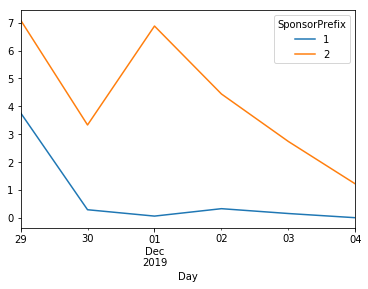

In [29]:
# Статистика по отдельному кастомеру по Спонсору

customer = 'Vectone TAP'

df_bss_processed[df_bss_processed.CustomerName == customer].\
groupby(['Day','SponsorPrefix'], as_index=False)['TotalProfit'].sum().\
pivot_table(values='TotalProfit',index=['Day']
                   ,columns='SponsorPrefix', aggfunc=np.sum).reset_index().sort_values(by='Day').fillna(0).set_index('Day')\
.plot()
plt.show()

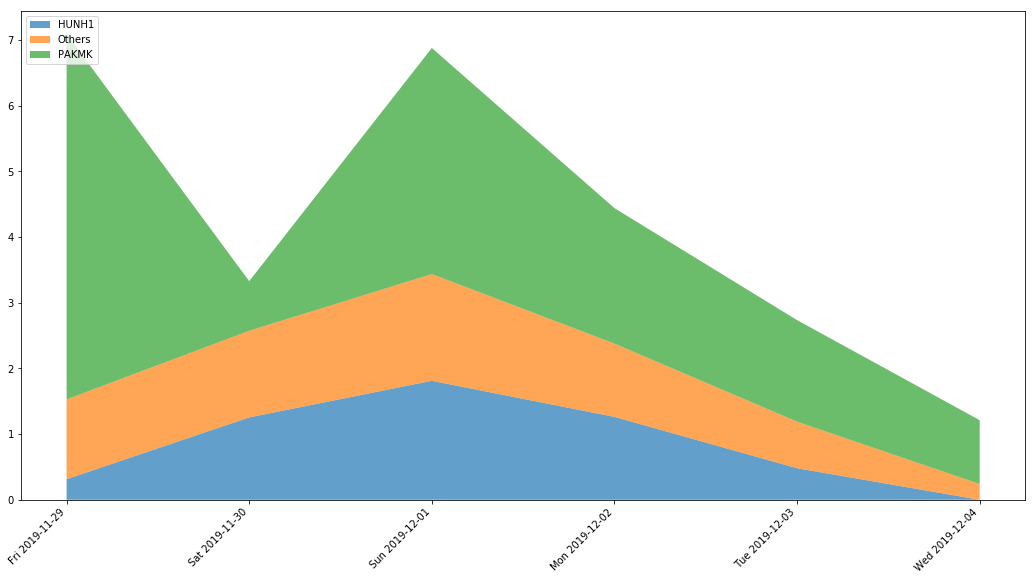

In [32]:
# Статистика по отдельному кастомеру и спонсору по Оператору

threshold = 1
customer = 'Vectone TAP'
sponsor = 2

df_temp = df_bss_processed[(df_bss_processed.CustomerName == customer) & (df_bss_processed.SponsorPrefix == sponsor)].copy()

s1 = df_temp.groupby(['Day','Tadig'], as_index=False)['TotalProfit'].sum()\
.groupby(['Tadig'])['TotalProfit'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed.Tadig.isin(list_other), ['Tadig']] = 'Others'

df_temp = df_temp.groupby(['Day','Tadig'], as_index=False)['TotalProfit'].sum()

df_temp = df_temp.pivot_table(values='TotalProfit',index=['Day']
                   ,columns='Tadig', aggfunc=np.sum).reset_index().sort_values(by='Day')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Day'].values, df_temp.drop('Day', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
xticks = df_temp.Day
plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

In [33]:
threshold = 0
customer = 'Vectone TAP'
sponsor = 1

df_temp = df_bss_processed[(df_bss_processed.CustomerName == customer) & (df_bss_processed.SponsorPrefix == sponsor)].copy()
df_temp = df_temp.\
groupby(['Day','Tadig'],as_index=False)['TotalProfit'].sum()\
.groupby('Tadig')['TotalProfit'].agg([('ProfitMin', np.min), ('ProfitSum', np.sum)]).reset_index()
list_breakthrough = df_temp[(df_temp.ProfitMin < 100) & (df_temp.ProfitSum > 5000)].Tadig.tolist()

df_bss_processed[df_bss_processed.Tadig.isin(list_breakthrough)].pivot_table(values='TotalProfit',index=['Day']
                   ,columns='Tadig', aggfunc=np.sum).reset_index().sort_values(by='Day').fillna(0).set_index('Day')\
.plot(figsize=(12,6))
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

In [15]:
df_bss_processed[(df_bss_processed.Day > '2019-07-10') & (df_bss_processed.Day < '2019-07-20')].sort_values(by='Day').head()

,Day,SponsorPrefix,CustomerName,Tadig,MOC,MTC,MOSMS,MTSMS,DATA,TotalProfit
155575,2019-07-11,1,Cloud 9 TAP,ALBVF,0.000,0.0,0.0000,0.0,5.54580,5.54580
156213,2019-07-11,1,Tottolli-Tech-Mobil,TURIS,0.000,0.0,0.0000,0.0,0.00000,0.00000
156214,2019-07-11,1,Cloud 9 TAP,TURTK,0.480,0.0,0.0000,0.0,3.61259,4.09259
156215,2019-07-11,1,Telzar 019 DMI RT,TURTK,0.000,0.0,0.7200,0.0,0.00000,0.72000
156216,2019-07-11,1,Cloud 9 TAP,TURTS,0.667,0.0,0.0744,0.0,67.51580,68.25720


In [34]:
threshold = 1
customer = 'Vectone TAP'
# sponsor = 1

df_temp = df_bss_processed[(df_bss_processed.Day > '2019-07-10') & (df_bss_processed.Day < '2019-07-20')].copy()

s1 = df_temp.groupby(['Day','Tadig'], as_index=False)['TotalProfit'].sum()\
.groupby(['Tadig'])['TotalProfit'].max()

list_other = s1[s1.values <= threshold].index.tolist()

df_temp.loc[df_bss_processed.Tadig.isin(list_other), ['Tadig']] = 'Others'

df_temp = df_temp.groupby(['Day','Tadig'], as_index=False)['TotalProfit'].sum()

df_temp = df_temp.pivot_table(values='TotalProfit',index=['Day']
                   ,columns='Tadig', aggfunc=np.sum).reset_index().sort_values(by='Day')

df_temp.fillna(0, inplace=True)

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(1,1,1)
ax.stackplot(df_temp['Day'].values, df_temp.drop('Day', axis=1).T, labels=df_temp.columns[1:], alpha=0.70)
ax.legend(loc='upper left')
xticks = df_temp.Day
plt.xticks(xticks, xticks.dt.strftime("%a %Y-%m-%d"), rotation=45, ha="right")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

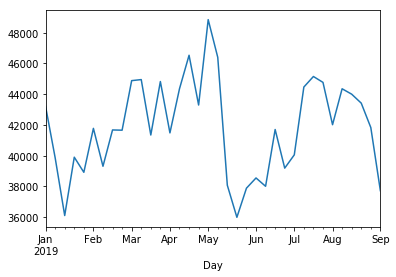

In [75]:
df_bss_processed.groupby('Day')['TotalProfit'].sum().plot()
plt.show()

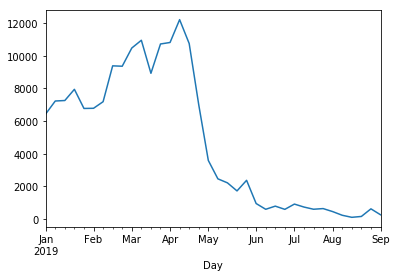

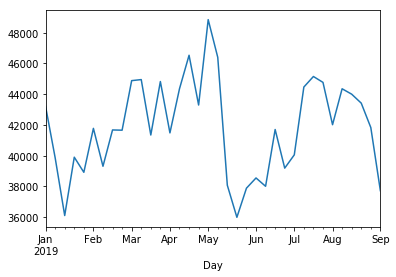

In [76]:
df_bss_processed[df_bss_processed.CustomerName == 'Telzar 019 DMI RT'].groupby('Day')['TotalProfit'].sum().plot()
plt.show()

df_bss_processed.groupby('Day')['TotalProfit'].sum().plot()
plt.show()

### Сделать:
1. Сделать график с Кастомерами с общей выручкой от 3 до 20 тыс. USD
2. Сделать график "прорыв года" для кастомеров с минимальным недельным профитом менее 500 USD в начале и общим готовым профитом более 7000 USD. На графике добавить кумулятивное значение и указать в какой момент был преодолен порого 10000 USD.

In [27]:
df_bss_source.head()
df_bss = df_bss_source.copy()
df_bss.SponsorPrefix.replace({42501:1, 26006:2, 45403:4, 51503:5}, inplace=True)
df_bss = df_bss.pivot_table(values=['Cost','Revenue'],index=['Day','SponsorPrefix','VisitedCountryId','VisitedNetworkId','Customer']
                   ,columns='UsageType', aggfunc=np.sum).reset_index()
df_bss.Day = pd.to_datetime(df_bss.Day, format='%Y%m%d')

df_bss.columns = [''.join(col) for col in df_bss.columns]

df_bss_processed = pd.merge(df_bss, df_customer, how='left', on='Customer')
df_bss_processed = pd.merge(df_bss_processed, df_tadig, how='left', on='VisitedNetworkId')
df_bss_processed['Month'] = df_bss_processed['Day'].values.astype('<M8[M]')
df_bss_processed = df_bss_processed[
    ['Month','SponsorPrefix','CustomerName','Tadig'
     ,'CostMOC','RevenueMOC','CostMTC','RevenueMTC','CostMOSMS','RevenueMOSMS','CostMTSMS','RevenueMTSMS','CostDATA','RevenueDATA']]

df_bss_processed.head()

,Month,SponsorPrefix,CustomerName,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
0,2019-10-01,1,Cloud 9 TAP,ALBVF,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.192310,6.385830
1,2019-10-01,1,KnowRoaming IMSI-RANGE TAP,ALBVF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027492,0.055057
2,2019-10-01,1,Naka TAP,ALBVF,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.819550,7.641530
3,2019-10-01,1,Multi-byte TAP,ALBVF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.393730,14.791700
4,2019-10-01,1,Tottolli-Tech-Mobil,ALBVF,0.28408,0.568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Выборака по спонсору

df_temp = df_bss_processed.loc[df_bss_processed.SponsorPrefix == 4].copy()
df_temp.head(3)

,Month,SponsorPrefix,CustomerName,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
881,2019-10-01,4,Dialoq - Genesisclub RT,AREDU,NaN,NaN,0.255767,0.52,1.148900,0.000000,NaN,NaN,NaN,NaN
1776,2019-10-01,4,Roamability Test RT,RUSBD,NaN,NaN,NaN,NaN,0.050059,0.100288,NaN,NaN,NaN,NaN
1777,2019-10-01,4,Roamability Test RT,RUS01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000219,0.000391


In [32]:
# Выборака Кастомеру

markup_abs_tolerance = 0.0
customer = 'Justworks Mobile' # df_bss_processed.loc[df_bss_processed.CustomerName.str.startswith('Clay RT'),'CustomerName'].unique()

df_temp = df_bss_processed.loc[df_bss_processed.CustomerName == customer].copy()

df_temp = df_temp.groupby(
        ['SponsorPrefix','Tadig'], as_index=False).sum()

df_diff = df_temp[
    ~np.isclose(df_temp.CostMOC * 2, df_temp.RevenueMOC, atol=markup_abs_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostMTC * 2, df_temp.RevenueMTC, atol=markup_abs_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostMOSMS * 2, df_temp.RevenueMOSMS, atol=markup_abs_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostMTSMS * 2, df_temp.RevenueMTSMS, atol=markup_abs_tolerance, equal_nan=True) |\
    ~np.isclose(df_temp.CostDATA * 2, df_temp.RevenueDATA, atol=markup_abs_tolerance, equal_nan=True)
]

def colorize(s):
    color_list = []
    for tariff_type in [['CostMOC','RevenueMOC'], ['CostMTC','RevenueMTC'],
                        ['CostMOSMS','RevenueMOSMS'], ['CostMTSMS','RevenueMTSMS'], ['CostDATA','RevenueDATA']]:
        if np.isclose(s[tariff_type[0]] * 2, s[tariff_type[1]], atol=markup_abs_tolerance, equal_nan=True):
            color_list.extend(['', ''])
        elif s[tariff_type[0]] * 2 > s[tariff_type[1]]:
            color_list.extend(['background-color: yellow', 'background-color: red'])
        else:
            color_list.extend(['background-color: yellow', 'background-color: #81EF21'])
    return color_list

cols = ['COUNTRY_NAME','TADIG_CODE','MOC','MOC_S2','MTC','MTC_S2','SMS','SMS_S2','DATA','MB_S2'
           ,'P4_LTE','P4_CAMEL','is_discounted','NETWORK_ID','SPONSOR']

display(df_diff.style.apply(colorize,
                            subset=['CostMOC','RevenueMOC','CostMTC','RevenueMTC','CostMOSMS','RevenueMOSMS',
                                    'CostMTSMS','RevenueMTSMS','CostDATA','RevenueDATA'], axis=1))

,SponsorPrefix,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
0,1,CHNCT,0,0,0,0,0.0509989,0.102,0,0,0,0
1,1,HKGHT,0,0,0,0,0.456073,0.912,0,0,0.0338105,0.0675972
2,1,HKGTC,0,0,0,0,0.120361,0.24,0,0,0.503739,1.00765
3,1,ITAOM,0,0,0,0,0,0,0,0,2.48686,4.97726
4,1,ITASI,0,0,0,0,0,0,0,0,0.000136774,0.000164032
5,1,JORMC,0,0,0,0,0.431502,0.863,0,0,1.1875,2.35809
6,1,JPNDO,0,0,0,0,0.420307,0.84,0,0,2.65519,5.31025
7,1,JPNJP,0,0,0,0,0.200018,0.4,0,0,28.9728,57.9448
8,1,KORKT,0,0,0,0,0.120088,0.24,0,0,0,0
9,1,KORSK,0,0,0,0,0.0480077,0.096,0,0,1.3829,2.76521


In [33]:
df_temp

,SponsorPrefix,Tadig,CostMOC,RevenueMOC,CostMTC,RevenueMTC,CostMOSMS,RevenueMOSMS,CostMTSMS,RevenueMTSMS,CostDATA,RevenueDATA
0,1,CHNCT,0.000000,0.000,0.000000,0.000000,0.050999,0.1020,0.0,0.0,0.000000,0.000000
1,1,HKGHT,0.000000,0.000,0.000000,0.000000,0.456073,0.9120,0.0,0.0,0.033810,0.067597
2,1,HKGTC,0.000000,0.000,0.000000,0.000000,0.120361,0.2400,0.0,0.0,0.503739,1.007652
3,1,ITAOM,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,2.486862,4.977260
4,1,ITASI,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.000137,0.000164
5,1,JORMC,0.000000,0.000,0.000000,0.000000,0.431502,0.8630,0.0,0.0,1.187502,2.358085
6,1,JPNDO,0.000000,0.000,0.000000,0.000000,0.420307,0.8400,0.0,0.0,2.655193,5.310250
7,1,JPNJP,0.000000,0.000,0.000000,0.000000,0.200018,0.4000,0.0,0.0,28.972790,57.944780
8,1,KORKT,0.000000,0.000,0.000000,0.000000,0.120088,0.2400,0.0,0.0,0.000000,0.000000
9,1,KORSK,0.000000,0.000,0.000000,0.000000,0.048008,0.0960,0.0,0.0,1.382896,2.765205


In [17]:
df_bss_processed[df_bss_processed.MTSMS > 8]\
.groupby(['SponsorPrefix','CustomerName','Tadig'], as_index=False)['MTSMS'].sum().sort_values(by='CustomerName')\
.to_csv(join(downloads,'overcharg.csv'), index=False)



In [1]:
%reset -f
from zeep import Client
from zeep.wsse.username import UsernameToken

connect = input("Choose connection (prod or lab):")

if connect == 'lab':
    user = 'lab_api@roamability.com'
    user = 'api_lab@dialoq.com'
    password = '25D55AD283AA400AF464C76D713C07AD' #Lab
    password = 'FAC4EC08B5FC0CCF8145BB79E8F24F47' #Lab
    api_link = 'https://172.20.39.7:8585/ocsapi/roamability/api/roamability.wsdl' #Lab
    api_link = 'https://labocsapi.roamability.com:6443/ocsapi/roamability/api/roamability.wsdl'
elif connect == 'prod':
    user = 'prod_api@roamability.com'
    password = '25D55AD283AA400AF464C76D713C07AD'
#     api_link = 'https://ocsapi.roamability.com:7443/ocsapi/roamability/api/roamability.wsdl'
#     api_link = 'https://ocsapi.roamability.com:7443/ocsapi/roamability/api/'
    api_link = 'https://ocsapi2.roamability.com:7443/ocsapi/roamability/api/roamability.wsdl'
#     api_link = 'http://172.20.35.10:8585/ocsapi/roamability/api/roamability.wsdl'
#     api_link = 'http://172.20.35.12:8585/ocsapi/roamability/api/roamability.wsdl'

user_name_token = UsernameToken(user, password)
user_name_token.use_digest = True
client = Client(api_link, wsse=user_name_token)

reseller = client.service.getResellerInfo()
accounts = client.service.getAccounts()

if reseller.result.code == '1':
    print('You are connected to Reseller: {}.\
    \nAvailable credit for the Reseller: {:.0f} USD.\n'.\
    format(reseller.reseller.resellerName,reseller.reseller.availableCredit))
else:
    print('Error in getting Reseller info: {}'.format(reseller.result.description))

if accounts.result.code == '1':
    accounts_dict = {account.accountId:account.accountName for account in accounts.accounts.accounts}
    print('The Reseller contains the following accounts:')
    for i,[account_id,account_name] in enumerate(accounts_dict.items()):
        print(' {:<5}{} (accountID: {})'.format(i,account_name,account_id))
else:
    print('Error in getting Account info: {}'.format(accounts.result.description))
    
# Subscriber in lab in STI account
#subscriber_id = client.service.getSubscriberById('934420')
#subscriber_iccid = client.service.getSubscriberByICCID('8997219121000031446')
# client.service.getSubscriberPrePaidPackages('831882', 1)
#subscriber_id

Choose connection (prod or lab):lab
You are connected to Reseller: Genesisclub RT.    
Available credit for the Reseller: 2 USD.

The Reseller contains the following accounts:
 0    Genesisclub Test sim cards (accountID: 352475)


In [2]:
from datetime import datetime
start_time = datetime.now()
for i in range(100):
    subscriber_id = client.service.getSubscriberById('934420')
    print(f'Result {i}: {subscriber_id.result.code}. Elapsed time: {datetime.now() - start_time}')

Result 0: 1. Elapsed time: 0:00:00.117695
Result 1: 1. Elapsed time: 0:00:00.233353
Result 2: 1. Elapsed time: 0:00:00.349073
Result 3: 1. Elapsed time: 0:00:00.456795
Result 4: 1. Elapsed time: 0:00:00.560472
Result 5: 1. Elapsed time: 0:00:00.659231
Result 6: 1. Elapsed time: 0:00:00.762932
Result 7: 1. Elapsed time: 0:00:00.866688
Result 8: 1. Elapsed time: 0:00:00.965392
Result 9: 1. Elapsed time: 0:00:01.066153
Result 10: 1. Elapsed time: 0:00:01.165857
Result 11: 1. Elapsed time: 0:00:01.263595
Result 12: 1. Elapsed time: 0:00:01.364325
Result 13: 1. Elapsed time: 0:00:01.466053
Result 14: 1. Elapsed time: 0:00:01.563791
Result 15: 1. Elapsed time: 0:00:01.659561
Result 16: 1. Elapsed time: 0:00:01.766249
Result 17: 1. Elapsed time: 0:00:01.871973
Result 18: 1. Elapsed time: 0:00:01.979679
Result 19: 1. Elapsed time: 0:00:02.083401
Result 20: 1. Elapsed time: 0:00:02.186160
Result 21: 1. Elapsed time: 0:00:02.291846
Result 22: 1. Elapsed time: 0:00:02.397565
Result 23: 1. Elapsed

### Поиск почему для MB низкий маркап в целом по спонсору

In [3]:
df_bss_source.head()

,Day,SponsorPrefix,VisitedCountryId,VisitedNetworkId,Customer,Cost,Revenue,UsageType
0,20191129,26006,11,30,172722,0.086341,0.186309,DATA
1,20191129,26006,14,50,172854,0.588189,1.269120,DATA
2,20191129,26006,14,51,172854,7.303400,15.758500,DATA
3,20191129,26006,14,52,172722,3.972200,8.570810,DATA
4,20191129,26006,14,52,172804,0.968480,2.089670,DATA


In [35]:
df_bss = df_bss_source.copy()
# df_bss['Markup'] = df_bss['Revenue'] / df_bss['Cost']
df_bss['Markup'] = df_bss_source.apply(lambda x: (x.Revenue/2) / x.Cost if x.Cost !=0 else 0, axis=1)
df_bss.SponsorPrefix.replace({42501:1, 26006:2, 45403:4, 51503:5}, inplace=True)
df_bss = df_bss.pivot_table(values='Markup',index=['Day','SponsorPrefix','VisitedCountryId','VisitedNetworkId','Customer']
                   ,columns='UsageType', aggfunc=np.mean).reset_index()
df_bss.Day = pd.to_datetime(df_bss.Day, format='%Y%m%d')
df_bss_processed = pd.merge(df_bss, df_customer, how='left', on='Customer')
df_bss_processed = pd.merge(df_bss_processed, df_tadig, how='left', on='VisitedNetworkId')
df_bss_processed = df_bss_processed[['Day','SponsorPrefix','CustomerName','Tadig','MOC','MTC','MOSMS','MTSMS','DATA']]
df_bss_processed.head(3)

,Day,SponsorPrefix,CustomerName,Tadig,MOC,MTC,MOSMS,MTSMS,DATA
0,2019-11-29,1,Cloud 9 TAP,ALBVF,NaN,NaN,NaN,NaN,1.058439
1,2019-11-29,1,Naka TAP,ALBVF,NaN,NaN,NaN,0.0,NaN
2,2019-11-29,1,MCN Telecom,ALBVF,NaN,NaN,1.001168,0.0,1.002200


In [36]:
# By CustomerName

df_bss_processed.loc[df_bss_processed.CustomerName == 'Vectone TAP']\
.groupby(['SponsorPrefix','CustomerName','Tadig'], as_index=False)\
['MOC','MTC','MOSMS','DATA'].mean().fillna('') #.to_csv(join(downloads,'MB_WRONG_COST.csv'), index=False)

,SponsorPrefix,CustomerName,Tadig,MOC,MTC,MOSMS,DATA
0,1,Vectone TAP,CHEOR,1.00228,0,,
1,1,Vectone TAP,GEOMT,,,,
2,1,Vectone TAP,GHAGT,1.00093,,,
3,1,Vectone TAP,INDSC,0.298606,0,1.00022,0.99811
4,1,Vectone TAP,JORMC,,,,
5,1,Vectone TAP,MDAMC,0.99982,,1.00228,
6,1,Vectone TAP,SRBNO,0.993622,0,1.00947,
7,1,Vectone TAP,SVNSM,1.00029,0,0.999595,
8,2,Vectone TAP,BGRCM,1.08286,0,1.08404,
9,2,Vectone TAP,CYPCT,1.07843,,,


In [37]:
# By Sponsor

df_bss_processed.loc[df_bss_processed.SponsorPrefix == 4]\
.groupby(['SponsorPrefix','Tadig'], as_index=False)\
['MOC','MTC','MOSMS','DATA'].mean().fillna('') #.to_csv(join(downloads,'MB_WRONG_COST.csv'), index=False)

,SponsorPrefix,Tadig,MOC,MTC,MOSMS,DATA
0,4,AREDU,0.50781,1.01645,0,1.07505
1,4,CHNCU,,,0.22355,1.07761
2,4,IDNSL,,,,1.04509
3,4,JPNDO,,,2.38996,0.974559
4,4,MYSMI,,,,2.05933
5,4,RUS01,,,16.5207,
6,4,SAUVG,,,,0.581436
7,4,THAWN,,,0,0.65257


In [39]:
df_bss = df_bss_source.copy()
df_bss.SponsorPrefix.replace({42501:1, 26006:2, 45403:4, 51503:5}, inplace=True)
df_bss.Day = pd.to_datetime(df_bss.Day, format='%Y%m%d')
df_bss_processed = pd.merge(df_bss, df_customer, how='left', on='Customer')
df_bss_processed = pd.merge(df_bss_processed, df_tadig, how='left', on='VisitedNetworkId')\
[['Day','SponsorPrefix','CustomerName','Tadig','Cost','Revenue','UsageType']]

df_bss_processed.loc[df_bss_processed.CustomerName == 'Vectone TAP']\
.groupby(['SponsorPrefix','Tadig','UsageType'])['Cost','Revenue'].sum().unstack().reset_index() #.to_csv(join(downloads,'REPORT_COST.csv'), index=False)

In [ ]:
9725420000000 - 9725420900000

In [41]:
len('9725420000000')

13